# Sum of Captcha Numbers

## Approach
This will be a 2 step process. We first train a simple model capable of doing MNIST digit recognition. Then we take 4 instances of this model and pass our 4 outputs through them and the output is taken as an input vector to the final layer. The output of the final layer is our answer which is compared with the label that we have. We first train the model and then train the whole thing end 2 end.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm import tqdm
from torchsummary import summary

In [2]:
train_data=np.load('Assign1/Data/data0.npy')
train_labels=np.load('Assign1/Data/lab0.npy')
for i in range(1,3):
    temp_data = np.load(f'Assign1/Data/data{i}.npy')
    temp_label = np.load(f'Assign1/Data/lab{i}.npy')
    train_data = np.concatenate((train_data,temp_data))
    train_labels = np.concatenate((train_labels,temp_label))
print(train_data.shape,train_labels.shape)

(30000, 40, 168) (30000,)


## Segmentation
We use multiple computer vision techniques to segment the numbers out into different images.

In [3]:
def seg_image(img):
    w,h = int(168*1.5),int(40*1.5)
    img = cv2.resize(img,(w, h))
    gray = cv2.copyMakeBorder(img, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
    gray = cv2.resize(gray,(w, h))
    kernel = np.ones((2, 2), np.uint8) 
    gray = cv2.erode(gray, kernel)
    letter_image_regions = []
 
    # finding the contours
    contours, hierarchy = cv2.findContours(gray.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
    for contour in contours:
      # Get the rectangle that contains the contour
      (x, y, w, h) = cv2.boundingRect(contour)

      # checking if any counter is too wide
      # if countour is too wide then there could be two letters joined together or are very close to each other
      if w / h > 1.25:
        # Split it in half into two letter regions
        half_width = int(w / 2)
        letter_image_regions.append((x, y, half_width, h))
        letter_image_regions.append((x + half_width, y, half_width, h))
      else:  
        letter_image_regions.append((x, y, w, h))
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])
    segmentation = []
    for i in range(len(letter_image_regions)):
        x,y,w,h = letter_image_regions[i]
#         print(w*h)
        if w*h > 100:
#             img_dil = cv2.dilate(gray[y - 2:y + h + 2, x - 2:x + w + 2],kernel)
            img_dil = gray[y - 2:y + h + 2, x - 2:x + w + 2]
            img_dil = cv2.copyMakeBorder(img_dil, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
            segmentation.append(cv2.dilate(img_dil,kernel))
#             segmentation.append(gray[y:y + h, x :x + w ])
    return segmentation

17


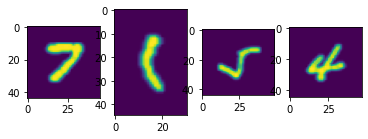

In [4]:
ind = 48
img = train_data[ind]
segs = seg_image(img)
zero = segs[-1]
print(train_labels[ind])
for i in range(len(segs)):
    plt.subplot(1,len(segs),i+1)
    plt.imshow(segs[i])

## Configuration
We define the global variables here

In [5]:
class CFG:
    batch_size=128
    momentum_value = 0.9
    epochs=50
    lr = 1e-2
    seed = 42
    num_workers=4
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model_name='custom'
    valid_size = 0.3
    size=28

## Dataset
We prepare the dataset by splitting it into train and cross validation. Then we add some augmentation to make the training process more robust. This includes rotation,translation,scaling,etc. We also add Erasing in augmentation

In [6]:
torch.manual_seed(CFG.seed)
RandAffine = transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.8, 1.2))


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
    transform=transforms.Compose([
        transforms.RandomAffine(degrees=45,  translate=(0.1, 0.1), scale=(0.8, 1.2)),
        transforms.RandomPerspective(p=0.3),
        transforms.ToTensor(),
#         RandAffine,
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.RandomErasing(p=0.3)
        ])),
    batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])),
     batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers)

## Model
We define our model here. Model summary is given below

In [101]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU(inplace=True))
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(inplace=True))
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU(inplace=True))
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.lin1 = nn.Sequential(nn.Dropout(p=0.5),
                                nn.Linear(128*7*7, 128),
                                nn.BatchNorm1d(128),
                                nn.ReLU(inplace=True))
        self.lin2 = nn.Sequential(nn.Dropout(0.5),
                                nn.Linear(128, 64),
                                nn.BatchNorm1d(64),
                                nn.ReLU(inplace=True))
        self.lin3 = nn.Sequential(nn.Dropout(0.5),
                                    nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.lin1(x)
        x = self.lin2(x)
        x = self.lin3(x)
        return x

    
class AverageMeter(object):
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        
    def update(self,val,n=1):
        self.val += val
        self.sum += val*n
        self.count += n
        self.avg = self.sum/self.count
    def accuracy(self):
        return self.sum/self.count

In [102]:
model = Net()
model = model.to(CFG.device)
summary(model,(1,28,28))
optimizer = optim.Adam(model.parameters(),lr=CFG.lr)
criterion = nn.CrossEntropyLoss()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
            Conv2d-4           [-1, 64, 28, 28]          18,496
       BatchNorm2d-5           [-1, 64, 28, 28]             128
              ReLU-6           [-1, 64, 28, 28]               0
         MaxPool2d-7           [-1, 64, 14, 14]               0
            Conv2d-8          [-1, 128, 14, 14]          73,856
       BatchNorm2d-9          [-1, 128, 14, 14]             256
             ReLU-10          [-1, 128, 14, 14]               0
        MaxPool2d-11            [-1, 128, 7, 7]               0
          Dropout-12                 [-1, 6272]               0
           Linear-13                  [-1, 128]         802,944
      BatchNorm1d-14                  [

In [67]:
from tqdm import tqdm
def train(model,train_loader, optimizer,criterion, epoch):
    train_loss = AverageMeter()
    train_accuracy = AverageMeter()
    model.train()
    correct = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(CFG.device), target.to(CFG.device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'epoch: {epoch} loss={loss.item()} batch_id={batch_idx}')
        train_loss.update(loss.item())
    train_accuracy.sum = correct
    train_accuracy.count = len(train_loader.dataset)
    return train_loss.avg,train_accuracy.accuracy()*100.0

def test(model, criterion,test_loader):
    model.eval()
    test_loss = AverageMeter()
    test_accuracy = AverageMeter()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(CFG.device), target.to(CFG.device)
            output = model(data)
            test_loss.update(criterion(output, target).item())
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
#     test_loss /= len(test_loader.dataset)
    test_accuracy.sum = correct
    test_accuracy.count = len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{}({}%)\n'.format(test_loss.avg, test_accuracy.sum,\
          len(test_loader.dataset),  100*test_accuracy.accuracy()))
    return test_loss.avg,100.0*test_accuracy.accuracy()

## Training
We now train the model and collect different statistics. The plots are given below

In [68]:
OUTPUT_DIR = './'
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []
best_loss = np.Inf
for epoch in range(1, CFG.epochs):
    trainy_loss,trainy_acc = train(model, train_loader, optimizer,criterion, epoch)
    train_accuracy.append(trainy_acc)
    train_losses.append(trainy_loss)
    testy_loss,testy_acc = test(model,criterion, test_loader)
    test_accuracy.append(testy_acc)
    test_losses.append(testy_loss)
    if testy_loss < best_loss:
        best_loss = testy_loss
        print("Saving Model")
        torch.save({'model': model.state_dict()},
                    OUTPUT_DIR+f'{CFG.model_name}_best.pth')

  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1000, Accuracy: 9655/10000(96.55%)

Saving Model


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0773, Accuracy: 9751/10000(97.50999999999999%)

Saving Model


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0757, Accuracy: 9760/10000(97.6%)

Saving Model


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0551, Accuracy: 9832/10000(98.32%)

Saving Model


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0543, Accuracy: 9825/10000(98.25%)

Saving Model


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0490, Accuracy: 9837/10000(98.37%)

Saving Model


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0459, Accuracy: 9839/10000(98.39%)

Saving Model


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0472, Accuracy: 9854/10000(98.54%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0402, Accuracy: 9856/10000(98.56%)

Saving Model


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0405, Accuracy: 9861/10000(98.61%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0411, Accuracy: 9870/10000(98.7%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0363, Accuracy: 9875/10000(98.75%)

Saving Model


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 9863/10000(98.63%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0377, Accuracy: 9879/10000(98.79%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0403, Accuracy: 9872/10000(98.72%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9897/10000(98.97%)

Saving Model


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0392, Accuracy: 9877/10000(98.77%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0383, Accuracy: 9879/10000(98.79%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Accuracy: 9883/10000(98.83%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Accuracy: 9882/10000(98.82%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0347, Accuracy: 9885/10000(98.85000000000001%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0355, Accuracy: 9885/10000(98.85000000000001%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Accuracy: 9888/10000(98.88%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9896/10000(98.96000000000001%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9904/10000(99.03999999999999%)

Saving Model


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9897/10000(98.97%)

Saving Model


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9902/10000(99.02%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9897/10000(98.97%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9898/10000(98.98%)

Saving Model


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9897/10000(98.97%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9910/10000(99.1%)

Saving Model


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9906/10000(99.06%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9908/10000(99.08%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9914/10000(99.14%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9915/10000(99.15%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9910/10000(99.1%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9913/10000(99.13%)

Saving Model


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9909/10000(99.09%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9902/10000(99.02%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9917/10000(99.17%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9910/10000(99.1%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9913/10000(99.13%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0348, Accuracy: 9903/10000(99.03%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9922/10000(99.22%)

Saving Model


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9924/10000(99.24%)

Saving Model


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9917/10000(99.17%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9912/10000(99.11999999999999%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9910/10000(99.1%)



epoch: 49 loss=0.37666091322898865 batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 69.77it/s]



Test set: Average loss: 0.0253, Accuracy: 9914/10000(99.14%)



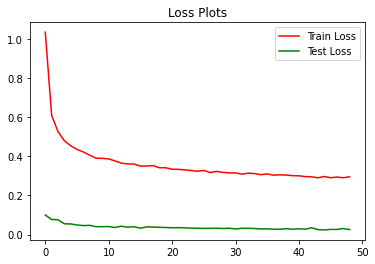

In [103]:
plt.title('Loss Plots')
plt.plot(train_losses,'r',label='Train Loss')
plt.plot(test_losses,'g',label = 'Test Loss')
plt.legend()
plt.savefig('lossplots.png')

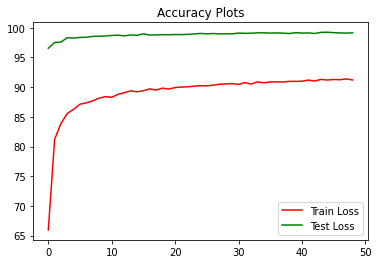

In [104]:
plt.title('Accuracy Plots')
plt.plot(train_accuracy,'r',label='Train Loss')
plt.plot(test_accuracy,'g',label = 'Test Loss')
plt.legend()
plt.savefig('accuracyplots.png')

## Captcha Dataset
We now create a dataset which returns the segmented numbers. We add a dummy 0 incase the number of segments are < 4. 

In [71]:
class CaptchaDataset(Dataset):
    def __init__(self,data,labels,dummy,transforms):
        super().__init__()
        self.data = data
        self.labels = labels
        self.transforms = transforms
        self.dummy = dummy
    
    def __len__(self):
        return self.labels.shape[0]
    
    def __getitem__(self,idx):
        img = self.data[idx]
        labels = self.labels[idx]
        segmented = seg_image(img)
        final = []
        if len(segmented) < 4:
            for i in range(4-len(segmented)):
                segmented.append(self.dummy)
        for i in range(len(segmented)):
            final.append(self.transforms(segmented[i]))
        return final,torch.tensor(labels)

In [72]:
num = train_data.shape[0]
indices = list(range(num))
np.random.seed(CFG.seed)
np.random.shuffle(indices)
split = int(np.floor(CFG.valid_size*num))
train_idx,valid_idx = indices[split:],indices[:split]

In [73]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((CFG.size,CFG.size)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = CaptchaDataset(train_data,train_labels,zero,transform)

train_sum_loader = DataLoader(train_dataset, batch_size = 1)


In [75]:
checkpoint = torch.load(f'{CFG.model_name}_best.pth')
sum_model = Net()
sum_model.load_state_dict(checkpoint['model'])
sum_model = sum_model.to(CFG.device)

## Evaluation
We now evaluate our trained model against the entire given dataset. Note: The training part included MNIST dataset and not the given dataset. We treat the entire given dataset as test dataset

In [76]:
sum_model.eval()
accuracy_metric = AverageMeter()
with torch.no_grad():
    for data, target in tqdm(train_sum_loader):
        target = target.to(CFG.device)
        outputs = 0
        for i in range(4):
            data[i] = data[i].to(CFG.device)
            output = sum_model(data[i])
            outputs += output.argmax(dim=1, keepdim=True)
#         outputs = outputs.flatten()
        if torch.unique(target==outputs).item():
            accuracy_metric.update(1) 


100%|██████████| 30000/30000 [02:32<00:00, 197.16it/s]


In [105]:
accuracy_metric.count = len(train_dataset)
print(f'Test Accuracy = {100*accuracy_metric.accuracy()}%')

Test Accuracy = 67.18666666666667%
